University of Helsinki, Master's Programme in Mathematics and Statistics  
MAST32001 Computational Statistics, Autumn 2023  
Luigi Acerbi  
Based on notebook by Antti Honkela 

# Lecture 10: Automatic differentiation, optimisation and maximum likelihood estimation

Background reading: please see Chapter 10 of the "Course notes" available in Moodle.

All the exercises can be done using either Autograd or PyTorch. Please see the course notes for examples and further comments before deciding which one to use.

## 0. Autograd tutorial

If you decide to use Autograd, you can try out the following tutorial.

*Note*: Autograd is simple to use but currently deprecated (the package is not under active development any more). It has been replaced by other machine learning frameworks like Pytorch or [JAX](https://github.com/google/jax), which do much more than just automated differentiation (e.g., GPU support). Since this course is not specifically about software implementations, you can use Autograd but keep in mind that for real applications you will likely need to use other software.

In [1]:
# Example usage of Autograd

import autograd.numpy as np
from autograd import grad

def sigmoid(x):
    """Logistic function."""
    return 1/(1+np.exp(-x))

d_sigmoid = grad(sigmoid)
# d_sigmoid is now a callable function that returns the derivative of sigmoid
print(d_sigmoid(0.0))
# See how it differs from the finite differences
h=1e-9
print( (sigmoid(h)-sigmoid(0.0))/(h) )

0.25
0.25000002068509275


## 0'. PyTorch tutorial

If you decide to use PyTorch, you can try out the following tutorial.

In [10]:
# Example usage of PyTorch
import torch

torch.set_default_dtype(torch.double)
# Uncomment this to run on GPU:

def sigmoid(x):
    """Logistic function (in PyTorch)."""
    return 1/(1+torch.exp(-x))

x = tensor(0.0, requires_grad=True)
v = sigmoid(x)
# Compute the gradient of the value w.r.t. specified input
print(torch.autograd.grad(v, x)[0].item())

# Alternative syntax that computes all gradients and stores with inputs:
v = sigmoid(x)
v.backward()
print(x.grad.item())
# See how it differs from the finite differences
h=1e-9
print( ((sigmoid(x+h)-sigmoid(x))/(h)).item() )

0.25
0.25
0.25000002068509275


### 1. Numerical and automatic differentiation

We will start by exploring different ways of differentiating the function $f(x) = x^3$.

1. Evaluate the derivative of $f(x)$ using the first-order finite difference approximation
$$ f'(x) \approx \frac{f(x+h) - f(x)}{h}. $$
2. Plot the absolute error of the finite difference approximation for a range of $h$ from $10^{-16}$ to $0.1$ at points $x = 10, 0.1, 0.001$. You can use `np.logspace(lower, upper, number_of_points)` or `torch.logspace(lower, upper, number_of_points)` to create the range for $h$.
3. Evaluate the derivative of the function at the same points as above using automatic differentiation. Print the numerical values and compare them to the above finite difference errors.


### 2. Optimisation of a function

Let us test some numerical optimisation methods using the famous Rosenbrock function (https://en.wikipedia.org/wiki/Rosenbrock_function) as the test case. 
The Rosenbrock function is defined by
$$ f(x, y) = (a-x)^2 + b(y-x^2)^2. $$
It has a global minimum of 0 at $(a, a^2)$. We use the usual parameters $a=1$, $b=100$.

1. Implement the Rosenbrock function and plot its values in the box $[-3, 3] \times [-3, 3]$.
2. Test a few different methods offered by `scipy.optimize.minimize()` or `torch.optim` for minimising the Rosenbrock function. Try different initial points. Which method seems the most appropriate?
3. For Autograd, compare `scipy.optimize.minimize()` both by providing it the gradient (`jac=...`) and without it using the `BFGS` and `L-BFGS-B` methods (https://docs.scipy.org/doc/scipy/reference/optimize.html). Compare the efficiency of the autograd gradients vs. numerical gradients evaluated by `minimize()` by default, in terms of number of function evaluations. *Hint*: The optimizer will return a dict with information about the optimization run, including the number of function evaluations `nfev`.
4. (optional) Study the optimisers in more detail by visualizing the optimization trajectory (i.e., the history of the values `x` being called by the optimizer). For Autograd, this can be achieved by using the `callback` functionality of `scipy.optimize.minimize()`. Plot the iterates for a few methods. A simple implementation of the callback:  
```python
    class recorder:
        def __init__(self):
            self.values = []
        
        def store(self, x):
            self.values.append(x)

    hist = recorder()
    res = minimize(..., callback=hist.store)
    iterates = np.vstack(hist.values)
```

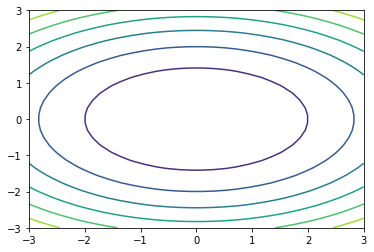

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
try:
    import autograd.numpy as np
except:
    import numpy as np

# Plotting example:
x = np.linspace(-3.0, 3.0, 30)
y = np.linspace(-3.0, 3.0, 30)
X, Y = np.meshgrid(x, y)
Z = X**2 + 2*Y**2
plt.contour(X, Y, Z)
plt.show()

### 3. Maximum likelihood estimation of linear regression and robust regression

In this task we will apply automatic differentiation to perform maximum likelihood estimation of a linear regression model.
We will use a linear regression model between two variables described as
$$ y_i = \beta x_i + \alpha + \epsilon_i, $$
where the noise term $\epsilon_i$ follows a known distribution, such as a standard normal $\mathcal{N}(0,1)$.

In order to fit the model to a set of observations $\{ (x_i, y_i) | i = 1, \dots, n \}$, we can solve $$\epsilon_i = y_i - \beta x_i - \alpha.$$ Assuming the residuals $\epsilon_i, i=1,\dots,n$ are independent, the log-likelihood of the model is
$$ L(\alpha, \beta) = \sum_{i=1}^n \log p(\epsilon_i | \alpha, \beta, x_i, y_i), $$
where $p(\epsilon_i | \alpha, \beta, x_i, y_i) = \mathcal{N}(\epsilon_i; \; 0, 1)$.

1. We will study a data set at points $x_i = i, i=0, \dots, 9$ with $y_i = x_i$ except $y_8 = c$. Create and plot this data set with $c=0$.
2. Derive and implement the log-likelihood function for linear regression and maximise it (i.e., minimise the negative log-likelihood) using the tools used in the previous task. Plot the fitted regression line in the same figure as the data.
3. Change the model to use a zero-mean [Laplace distribution](https://en.wikipedia.org/wiki/Laplace_distribution) for the residuals $\epsilon_i$, that is $p(\epsilon_i | \alpha, \beta, x_i, y_i) = \text{Laplace}(\epsilon_i; \; 0, 1)$. Repeat the previous task.
4. Repeat the exercise for different values of $c$. What do you observe? Can you make the two fitted models have slopes of different signs?

*Hint*: You can fix the scale/variance parameter of the distributions to any value you like, such as 1. This is because in the optimisation the scale will only affect an additive constant and the scale of the function but it will not change the optimum.

### 4. Linear regression with real data

In this task we will apply the same linear model to real data.
We will use data from the Framingham Heart Study that studies the association between heart disease and its causes.
A description of the data and its fields can be found below.

1. Load the data using the below code and plot the data.
2. Implement the log-likelihood function and maximise it (i.e. minimise the negative log-likelihood) using the tools used in the previous task. Plot the fitted regression line in the same figure as the data.
3. Change the model to use the Laplace distribution for the residuals $\epsilon_i$. Repeat the previous task.

#### Description of the `fram` dataset

(from http://www.maths.utas.edu.au/DHStat/Data/Flow.html)

> Data from the Framingham Heart study. In 1948, the study was initiated to identify the common factors or characteristics that contribute to CVD by following its development over time in group of participants who had not yet developed overt symptoms of CVD or suffered a heart attack or stroke.
>
> The researchers recruited 5,209 men and women between the ages of 30 and 62 from the town of Framingham, Massachusetts. Every two years, a series of extensive physical examinations and lifestyle interviews were conducted.
>
> This data set is subset of the Framingham Heart study data. The data is stored as 4 columns. Each row represents a single subject. 

| Column | Description |
| :- | :- |
| ID | a number which uniquely identifies the subject 
| SEX |	Subjects gender |
| AGE |	Age at examination 1 |
| FRW |	Framingham relative weight - the ratio of the subjects weight to the median weight for their sex-height group |
| SBP |	Systolic blood pressure, examination 1 |
| SBP10 | Systolic blood pressure, examination 10 |
| DBP |	Diastolic blood pressure, examination 1 |
| CHOL | Serum cholesterol |
| CIG | Number of cigarettes smoked per day |
| CHD | Coronary heart disease diagnosis, 0 - no evidence of CHD through examination 10, 1 - pre-existing CHD at examination 1, CHD 2-10 - examination at which CHD first diagnosed |
| YRS_CHD | Person years observation until withdrawal or first CHD event. pre - pre-existing condition 0-18 - years |
| DEATH | 0 - alive at examination 10 2-10 - first examination that had been scheduled following the date of death |
| YRS_DTH | Person years observation for mortality |
| CAUSE | Cause of death |

In [4]:
import pandas as pd
import autograd.numpy as np

# load the data from CSV file using pandas
fram = pd.read_csv('https://raw.githubusercontent.com/lacerbi/compstats-files/main/data/fram.txt', sep='\t')

# convert the variables of interest to numpy arrays for autograd compatibility
# input: Framingham relative weight - the ratio of the subjects weight to the median weight for their sex-height group
x = np.array(fram['FRW'])
# target: Systolic blood pressure, examination 1
y = np.array(fram['SBP'])

fram.head()

,ID,SEX,AGE,FRW,SBP,SBP10,DBP,CHOL,CIG,CHD,YRS_CHD,DEATH,YRS_DTH,CAUSE
0,4988,female,57,135,186,NaN,120,150,0,1,pre,7,11,unknown
1,3001,female,60,123,165,NaN,100,167,25,0,16,10,17,unknown
2,5079,female,54,115,140,NaN,90,213,5,0,8,8,13,unknown
3,5162,female,52,102,170,NaN,104,280,15,0,10,7,11,unknown
4,4672,female,45,99,185,NaN,105,326,20,0,8,10,17,unknown
